In [17]:
import numpy as np
import pandas as pd
from scipy.linalg import cholesky, eigvals
from scipy import stats
from scipy.optimize import minimize 
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import time



In [ ]:
#Problem 2:

#Use the data in problem1.csv. Fit a Normal Distribution and a Generalized T distribution to this data. Calculate the VaR and ES for both fitted distributions.

#Overlay the graphs the distribution PDFs, VaR, and ES values. What do you notice? Explain the differences.

#Problem 2.1

#Use the data in problem1.csv. Fit a Normal Distribution and a Generalized T distribution to this data. Calculate the VaR and ES for both fitted distributions.

In [40]:
problem1 = pd.read_csv('problem1.csv')

In [19]:
def cal_VaR_ES_norm(returns, n=10000, alpha=0.05):
    mu = returns.mean()
    sigma = returns.std()
    simu_returns = np.random.normal(mu, sigma, n)
    simu_returns.sort()
    n = alpha * simu_returns.size
    iup = int(np.ceil(n))
    idn = int(np.floor(n))
    VaR = (simu_returns[iup] + simu_returns[idn]) / 2

    ES = np.mean(simu_returns[0:idn])

    return -VaR, -ES, simu_returns

In [20]:
def MLE_t(params, returns):
    df, loc, scale = params
    neg_LL = -1 * np.sum(stats.t.logpdf(returns, df=df, loc=loc, scale=scale))
    return(neg_LL)

def cal_VaR_MLE_t(returns, n=10000, alpha=0.05):
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0] - 1},
        {'type': 'ineq', 'fun': lambda x: x[2]}
    ]
    
    res = minimize(MLE_t, x0=[10, returns.mean(), returns.std()], args=(returns,), constraints=constraints)
    
    df, loc, scale = res.x
    simu_returns = stats.t.rvs(df, loc=loc, scale=scale, size=n)
    simu_returns.sort()
    n = alpha * simu_returns.size
    iup = int(np.ceil(n))
    idn = int(np.floor(n))
    VaR = (simu_returns[iup] + simu_returns[idn]) / 2

    ES = np.mean(simu_returns[0:idn])

    return -VaR, -ES, simu_returns

In [22]:
VaR_norm, ES_norm, simu_norm = cal_VaR_ES_norm(problem1['x'])
VaR_t, ES_t, simu_t = cal_VaR_MLE_t(problem1['x'])
print("VaR_norm is {}, ES_norm is {},VaR_t is {},ES_t is {}".format(VaR_norm, ES_norm, VaR_t, ES_t))

VaR_norm is 0.08355621501311035, ES_norm is 0.10434488652155736,VaR_t is 0.07695912501988322,ES_t is 0.11612699745689016


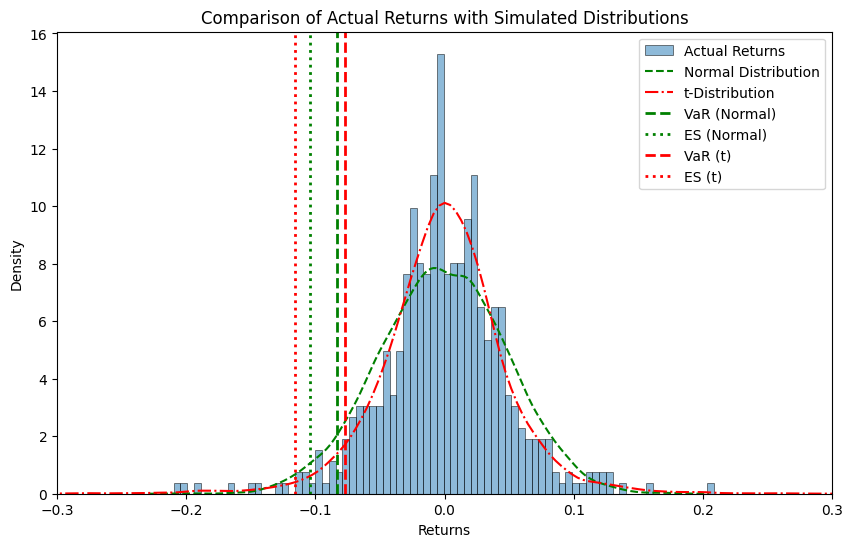

In [24]:


# Assuming 'problem1['x']' is your actual data, and 'simu_norm', 'simu_t' are your simulated data
# Also assuming 'VaR_norm', 'ES_norm', 'VaR_t', 'ES_t' are already calculated

fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram for the actual returns
ax.hist(problem1['x'], bins=80, density=True, alpha=0.5, label='Actual Returns', edgecolor='black', linewidth=0.7)

# Plot KDE for the normal and t-distribution simulations
sns.kdeplot(simu_norm, ax=ax, label='Normal Distribution', color='green', linestyle='--')
sns.kdeplot(simu_t, ax=ax, label='t-Distribution', color='red', linestyle='-.')

# Add VaR and ES for normal distribution
ax.axvline(x=-VaR_norm, color='green', linestyle='--', linewidth=2, label='VaR (Normal)')
ax.axvline(x=-ES_norm, color='green', linestyle=':', linewidth=2, label='ES (Normal)')

# Add VaR and ES for t distribution
ax.axvline(x=-VaR_t, color='red', linestyle='--', linewidth=2, label='VaR (t)')
ax.axvline(x=-ES_t, color='red', linestyle=':', linewidth=2, label='ES (t)')

# Set x limits for better visualization
ax.set_xlim(-0.3, 0.3)

# Enhance the plot
ax.set_title('Comparison of Actual Returns with Simulated Distributions')
ax.set_xlabel('Returns')
ax.set_ylabel('Density')
ax.legend()

plt.show()


In [38]:
#Problem 1 tests
import problem_1 as qrm
from scipy.optimize import minimize
from scipy import stats

In [30]:
#problem3
portfolio = pd.read_csv("portfolio.csv")
prices = pd.read_csv("DailyPrices.csv")

In [39]:

def fit_MLE_t(returns, n=10000, alpha=0.05):
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0] - 1},
        {'type': 'ineq', 'fun': lambda x: x[2]}
    ]
    
    res = minimize(MLE_t, x0=[10, returns.mean(), returns.std()], args=(returns,), constraints=constraints)
    
    df, loc, scale = res.x[0], res.x[1], res.x[2]
    return df, loc, scale

codes = ['A', 'B', 'C', 'all']

for code in codes:
    Total_Value, assets_prices, holdings, delta = qrm.get_single_portfolio(portfolio, prices, code)
    assets_returns = qrm.return_calculate(assets_prices)
    assets_returns.drop('Date', axis=1, inplace=True)
    norm_assets_returns = assets_returns - assets_returns.mean()

    parameters = []
    assets_returns_cdf = pd.DataFrame()
    for stock in norm_assets_returns.columns.tolist():
        this_return = norm_assets_returns[stock]
        params = fit_MLE_t(this_return)
        parameters.append(params)
    
        assets_returns_cdf[stock] = stats.t.cdf(norm_assets_returns[stock], df=params[0], loc=params[1], scale=params[2])
    
    spearman_corr_matrix = assets_returns_cdf.corr(method='spearman')
    simu_sample = qrm.multivar_norm_simu(spearman_corr_matrix, method='pca')
    simu_sample = pd.DataFrame(simu_sample, columns=assets_returns.columns)

    simu_sample_cdf = pd.DataFrame()
    for stock in simu_sample.columns.tolist():
        simu_sample_cdf[stock] = stats.norm.cdf(simu_sample[stock], loc=0, scale=1)

    simu_returns = pd.DataFrame()
    for i, stock in enumerate(simu_sample.columns.tolist()):
        simu_returns[stock] = stats.t.ppf(simu_sample_cdf[stock], df=parameters[i][0], loc=parameters[i][1], scale=parameters[i][2])

    assets_prices.drop('Date', axis=1, inplace=True)
    simu_prices = np.dot(simu_returns * assets_prices.tail(1).values.reshape(assets_prices.shape[1],), holdings)

    VaR_T, ES_T, ret = qrm.cal_VaR_hist(simu_prices)
    
    print(f"Results for Portfolio {code}:")
    print(f"  Total Value: {Total_Value}")
    print(f"  VaR: {VaR_T}")
    print(f"  ES: {ES_T}\n")

Results for Portfolio A:
  Total Value: 299950.05907389
  VaR: 8014.67506884616
  ES: 10564.93487157745

Results for Portfolio B:
  Total Value: 294385.59081765
  VaR: 6631.648868483114
  ES: 8700.292535086668

Results for Portfolio C:
  Total Value: 270042.83052769996
  VaR: 5677.616640642604
  ES: 7496.824808074901

Results for Portfolio all:
  Total Value: 864378.4804192402
  VaR: 20093.25982681004
  ES: 26479.89157687359



In [11]:
VaR_norm, ES_norm, simu_norm = cal_VaR_ES_norm(problem1)
VaR_t, ES_t, simu_t = cal_VaR_MLE_t(problem1)
print("VaR_norm is {}, ES_norm is {},VaR_t is {},ES_t is {}".format(VaR_norm, ES_norm, VaR_t, ES_t))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.